In [2]:
import json, sys, os, glob, re
from os import listdir

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve, ShuffleSplit, train_test_split
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer

import warnings
warnings.filterwarnings("ignore")

In [3]:
%load_ext autoreload
%autoreload 2

sys.path.insert(0, 'src')
from helper import *
from eda import *
from train import *                       
from etl import *

In [14]:
dir_ = 'data/raw/train_c'
the_csv_youre_using = listdir(dir_)[0] # gets first file you have in `data/raw/train_c` directory
print(the_csv_youre_using)

mergedtable = readfilerun_simple(os.path.join(dir_, the_csv_youre_using), dir_) # merges losslog. make sure you have losslog in the same train_c directory
df = genfeat(mergedtable) # generates all the adjacent features we train on!
df

20220201T010740_200-100-true-200-10000-200-iperf.csv


,Time,IP1,Port1,IP2,Port2,Proto,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts,...,total_pkts,pkt sum,longest_seq,mean_tdelta,max_tdelta,number_ms,total_pkt_sizes,pkt_ratio,time_spread,byte_ratio
0,1643677660,192.168.96.3,47330,192.168.48.2,5001,6,13664,60,11,1,...,12,13724,11,0.000000,0,1,13724,1143.666667,0,1143.666667
1,1643677661,192.168.96.3,47330,192.168.48.2,5001,6,51000,1520,34,26,...,60,52520,3,13.694915,402,8,52520,875.333333,808,875.333333
2,1643677662,192.168.96.3,47330,192.168.48.2,5001,6,42000,1456,28,28,...,56,43456,2,7.400000,399,9,43456,776.000000,407,776.000000
4,1643677663,192.168.96.3,47330,192.168.48.2,5001,6,63000,1196,42,23,...,65,64196,3,12.656250,400,11,64196,987.630769,810,987.630769
5,1643677664,192.168.96.3,47330,192.168.48.2,5001,6,42000,728,28,14,...,42,42728,2,9.878049,399,7,42728,1017.333333,405,1017.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,1643677957,192.168.96.3,47330,192.168.48.2,5001,6,1807500,24232,1205,466,...,1671,1831732,10,0.583234,33,243,1831732,1096.189108,974,1096.189108
304,1643677958,192.168.96.3,47330,192.168.48.2,5001,6,1576500,21788,1051,419,...,1470,1598288,7,0.675970,36,199,1598288,1087.270748,993,1087.270748
305,1643677959,192.168.96.3,47330,192.168.48.2,5001,6,2160000,29224,1440,562,...,2002,2189224,8,0.493253,34,223,2189224,1093.518482,987,1093.518482
306,1643677960,192.168.96.3,47330,192.168.48.2,5001,6,1881000,26884,1254,517,...,1771,1907884,8,0.554802,35,210,1907884,1077.291925,982,1077.291925


In [5]:
df[['loss', 'latency', 'switch_label']] # labels!

,loss,latency,switch_label
0,100,200,200
1,100,200,200
2,100,200,200
4,100,200,200
5,100,200,200
...,...,...,...
303,10000,200,200
304,10000,200,200
305,10000,200,200
306,10000,200,200


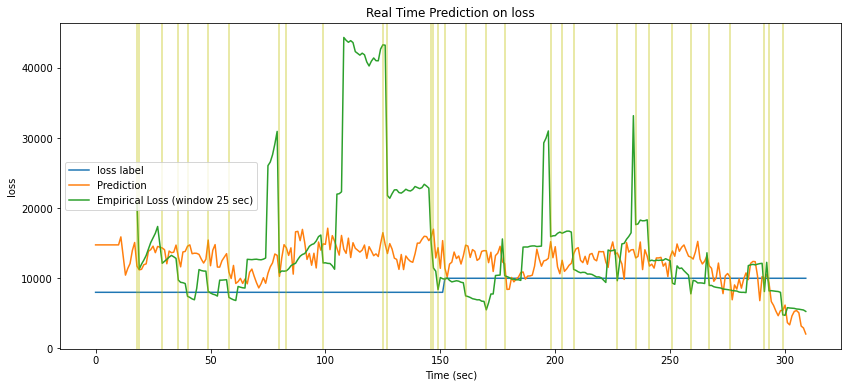

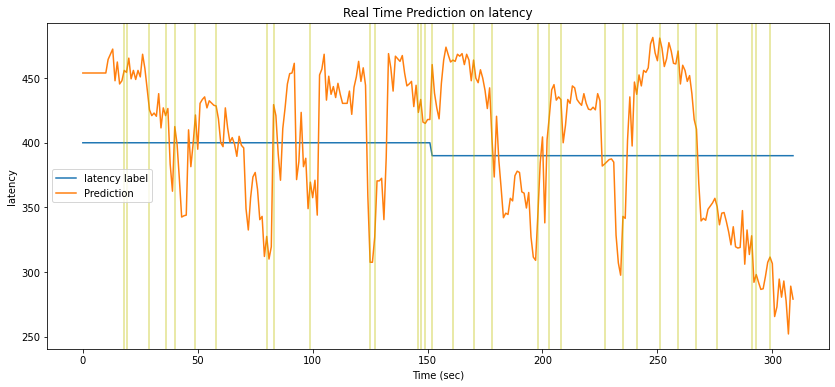

In [48]:
def gen_model(df, label, emplosswindow=25):
    '''generates predictive model and outputs predictions to new column in input df'''
    if(label=='loss'):
        # latency features
        indexcol = ['byte_ratio', 'pkt_ratio', 'time_spread', 'total_bytes', '2->1Pkts']
    else:
        # loss features
        indexcol = ['total_pkts', 'total_pkt_sizes', '2->1Bytes', 'number_ms', 'mean_tdelta', 'max_tdelta'] 
        
    ## takes transformed datababy from outputs (should be in gdrive)
    ct = pd.read_csv('outputs/combined_transform.csv').rename(
        {'mean_tdelta.1': 'mean_tdelta_amin', 'mean_tdelta.2':'mean_tdelta_amax'}, 
        axis=1)

    X_train, X_test, y_train, y_test = train_test_split(
        ct[[x for x in indexcol if x in df.columns]], ct[label])
    # print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    mdl = RandomForestRegressor(n_estimators=100, n_jobs=4)
    mdl = mdl.fit(X_train,y_train)

    df['prediction'] = mdl.predict(df[indexcol].rolling(10).mean().bfill()) # prediction on mean aggregation

    # fig = plt.figure()
    def emp_loss(df, window=25):
        '''returns empirical loss of a dataframe with the provided data over a specified window of time.'''
        return (df['total_pkts'].rolling(window, min_periods=1).sum() / 
            df['event'].str.replace('switch', '').str.split(';').str.len().fillna(0).rolling(window, min_periods=1).sum())


    df[[label, 'prediction']].plot(
        figsize=(14,6), title=f'Real Time Prediction on {label}', 
        xlabel='Time (sec)', ylabel=label)
    if (label=='loss'):
        emp_loss(df, emplosswindow).plot()
    
    if(label=='loss'):
        plt.legend([
            f'{label} label', 
            'Prediction',
            f'Empirical Loss (window {emplosswindow} sec)',
            ], loc='center left')
    else:
        plt.legend([
            f'{label} label', 
            'Prediction',
            ], loc='center left')
    for i in df[~df['event'].isnull()].index:
        plt.axvline(x=i, color='y', alpha=.45)
    
    ## adds new column to df
    df[f'pred_{label}'] = mdl.predict(df[indexcol].rolling(10,min_periods=1).mean())
    
    return mdl

# 
lossmodel = gen_model(df, 'loss')
latmodel = gen_model(df, 'latency')

In [17]:
df[['loss', 'latency', 'pred_loss', 'pred_latency']]

,loss,latency,pred_loss,pred_latency
0,100,200,580.0,498.5
1,100,200,136.0,398.0
2,100,200,144.0,380.0
4,100,200,123.0,390.5
5,100,200,135.0,391.5
...,...,...,...,...
303,10000,200,12430.0,297.0
304,10000,200,12280.0,333.5
305,10000,200,11800.0,297.2
306,10000,200,12050.0,277.9


In [22]:
# trying to smooth our the wigglies we arent interested in
df[['smoothed_pred_loss', 'smoothed_pred_latency']] = df[['pred_loss', 'pred_latency']].rolling(20,min_periods=1).mean()
df[['smoothed_pred_loss', 'smoothed_pred_latency']]

,smoothed_pred_loss,smoothed_pred_latency
0,580.000000,498.500
1,358.000000,448.250
2,286.666667,425.500
4,245.750000,416.750
5,223.600000,411.700
...,...,...
303,10950.250000,295.025
304,10856.750000,297.375
305,10743.250000,297.735
306,10684.750000,297.380


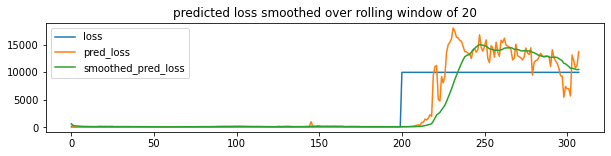

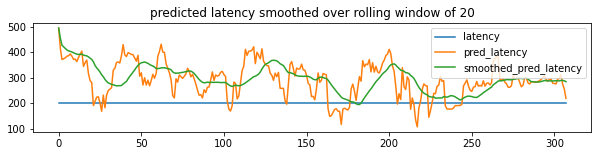

In [9]:
def plot_different_windowsizes(windowsize=20):
    tempdf = df[['loss', 'pred_loss', 'latency', 'pred_latency']]
    tempdf['smoothed_pred_loss'] = tempdf['pred_loss'].rolling(windowsize,min_periods=1).mean()
    tempdf['smoothed_pred_latency'] = tempdf['pred_latency'].rolling(windowsize,min_periods=1).mean()
    tempdf[['loss', 'pred_loss', 'smoothed_pred_loss']].plot(title=f'predicted loss smoothed over rolling window of {windowsize}', figsize=(10,2))
    tempdf[['latency', 'pred_latency', 'smoothed_pred_latency']].plot(title=f'predicted latency smoothed over rolling window of {windowsize}', figsize=(10,2))
plot_different_windowsizes()

In [10]:
# for i in range(10, 50, 10):
#     plot_different_windowsizes(i)

<AxesSubplot:title={'center':'loss prediction diffs'}>

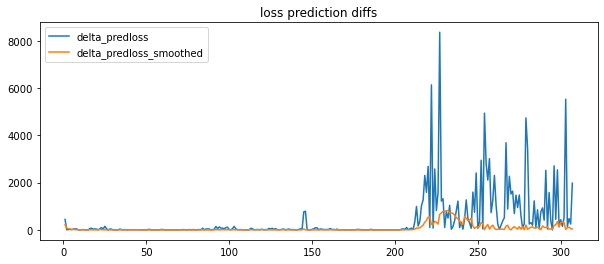

In [23]:
df[['delta_predloss_smoothed', 'delta_predloss']] = df[['smoothed_pred_loss', 'pred_loss']].diff().abs()
df[['delta_predloss', 'delta_predloss_smoothed']].plot(title='loss prediction diffs', figsize=(10,4))

<AxesSubplot:title={'center':'loss prediction diffs'}>

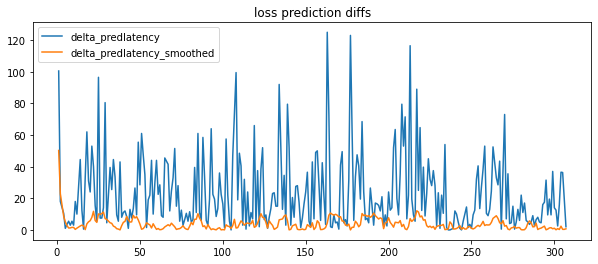

In [24]:
df[['delta_predlatency_smoothed', 'delta_predlatency']] = df[['smoothed_pred_latency', 'pred_latency']].diff().abs()
df[['delta_predlatency', 'delta_predlatency_smoothed']].plot(title='loss prediction diffs', figsize=(10,4))

yeah, probably a good idea to smooth it out or something.

In [25]:
# TODO find that threshold for a significant delta in predictions!
# TODO test this on more interesting dane runs! latency was the same in this analysis.
df

,Time,IP1,Port1,IP2,Port2,Proto,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts,...,pred_loss,pred_latency,loss_pct,latency_pct,smoothed_pred_loss,smoothed_pred_latency,delta_predloss_smoothed,delta_predloss,delta_predlatency_smoothed,delta_predlatency
0,1643677660,192.168.96.3,47330,192.168.48.2,5001,6,13664,60,11,1,...,580.0,498.5,NaN,NaN,580.000000,498.500,NaN,NaN,NaN,NaN
1,1643677661,192.168.96.3,47330,192.168.48.2,5001,6,51000,1520,34,26,...,136.0,398.0,-0.765517,-0.201605,358.000000,448.250,222.000000,444.0,50.250,100.5
2,1643677662,192.168.96.3,47330,192.168.48.2,5001,6,42000,1456,28,28,...,144.0,380.0,0.058824,-0.045226,286.666667,425.500,71.333333,8.0,22.750,18.0
4,1643677663,192.168.96.3,47330,192.168.48.2,5001,6,63000,1196,42,23,...,123.0,390.5,-0.145833,0.027632,245.750000,416.750,40.916667,21.0,8.750,10.5
5,1643677664,192.168.96.3,47330,192.168.48.2,5001,6,42000,728,28,14,...,135.0,391.5,0.097561,0.002561,223.600000,411.700,22.150000,12.0,5.050,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,1643677957,192.168.96.3,47330,192.168.48.2,5001,6,1807500,24232,1205,466,...,12430.0,297.0,0.801449,0.056940,10950.250000,295.025,24.500000,5530.0,0.275,16.0
304,1643677958,192.168.96.3,47330,192.168.48.2,5001,6,1576500,21788,1051,419,...,12280.0,333.5,-0.012068,0.122896,10856.750000,297.375,93.500000,150.0,2.350,36.5
305,1643677959,192.168.96.3,47330,192.168.48.2,5001,6,2160000,29224,1440,562,...,11800.0,297.2,-0.039088,-0.108846,10743.250000,297.735,113.500000,480.0,0.360,36.3
306,1643677960,192.168.96.3,47330,192.168.48.2,5001,6,1881000,26884,1254,517,...,12050.0,277.9,0.021186,-0.064939,10684.750000,297.380,58.500000,250.0,0.355,19.3


In [38]:
df[['loss_pct', 'latency_pct']] = df[['pred_loss', 'pred_latency']].pct_change(10)
df[['loss_pct', 'latency_pct']].plot()

KeyError: "None of [Index(['pred_loss', 'pred_latency'], dtype='object')] are in the [columns]"

<AxesSubplot:title={'center':'predicted latency smoothed over rolling window of 10'}>

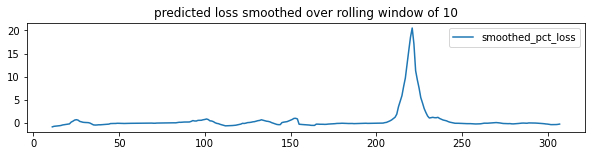

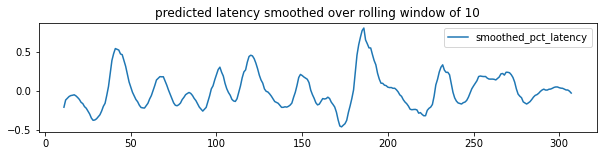

In [33]:
windowsize = 10
tempdf = df[['loss', 'pred_loss', 'latency', 'pred_latency']]
tempdf['smoothed_pred_loss'] = tempdf['pred_loss'].rolling(windowsize,min_periods=1).mean()
tempdf['smoothed_pred_latency'] = tempdf['pred_latency'].rolling(windowsize,min_periods=1).mean()
tempdf['smoothed_pct_loss'] = tempdf['smoothed_pred_loss'].pct_change(10)
tempdf['smoothed_pct_latency'] = tempdf['smoothed_pred_latency'].pct_change(10)
tempdf[['smoothed_pct_loss']].plot(title=f'predicted loss smoothed over rolling window of {windowsize}', figsize=(10,2))
tempdf[['smoothed_pct_latency']].plot(title=f'predicted latency smoothed over rolling window of {windowsize}', figsize=(10,2))

In [ ]:
df[['delta_predloss_smoothed','delta_predlatency_smoothed']].pct_change()

KeyError: "None of [Index(['delta_predloss_smoothed', 'delta_predlatency_smoothed'], dtype='object')] are in the [columns]"

,Time,IP1,Port1,IP2,Port2,Proto,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts,...,mean_tdelta,max_tdelta,number_ms,total_pkt_sizes,pkt_ratio,time_spread,byte_ratio,prediction,pred_loss,pred_latency
0,1643677660,192.168.96.3,47330,192.168.48.2,5001,6,13664,60,11,1,...,0.000000,0,1,13724,1143.666667,0,1143.666667,368.5,1339.0,499.0
1,1643677661,192.168.96.3,47330,192.168.48.2,5001,6,51000,1520,34,26,...,13.694915,402,8,52520,875.333333,808,875.333333,368.5,109.0,414.5
2,1643677662,192.168.96.3,47330,192.168.48.2,5001,6,42000,1456,28,28,...,7.400000,399,9,43456,776.000000,407,776.000000,368.5,104.5,369.5
4,1643677663,192.168.96.3,47330,192.168.48.2,5001,6,63000,1196,42,23,...,12.656250,400,11,64196,987.630769,810,987.630769,368.5,101.5,359.5
5,1643677664,192.168.96.3,47330,192.168.48.2,5001,6,42000,728,28,14,...,9.878049,399,7,42728,1017.333333,405,1017.333333,368.5,104.0,379.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,1643677957,192.168.96.3,47330,192.168.48.2,5001,6,1807500,24232,1205,466,...,0.583234,33,243,1831732,1096.189108,974,1096.189108,306.5,11030.0,306.5
304,1643677958,192.168.96.3,47330,192.168.48.2,5001,6,1576500,21788,1051,419,...,0.675970,36,199,1598288,1087.270748,993,1087.270748,315.0,10490.0,315.0
305,1643677959,192.168.96.3,47330,192.168.48.2,5001,6,2160000,29224,1440,562,...,0.493253,34,223,2189224,1093.518482,987,1093.518482,243.0,12370.0,243.0
306,1643677960,192.168.96.3,47330,192.168.48.2,5001,6,1881000,26884,1254,517,...,0.554802,35,210,1907884,1077.291925,982,1077.291925,225.5,12310.0,225.5


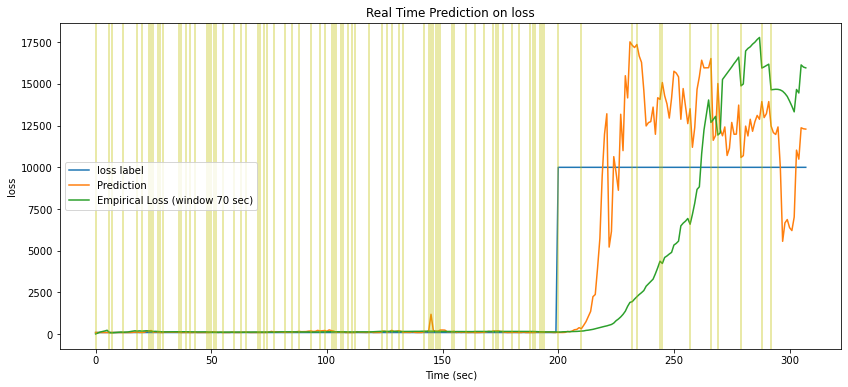

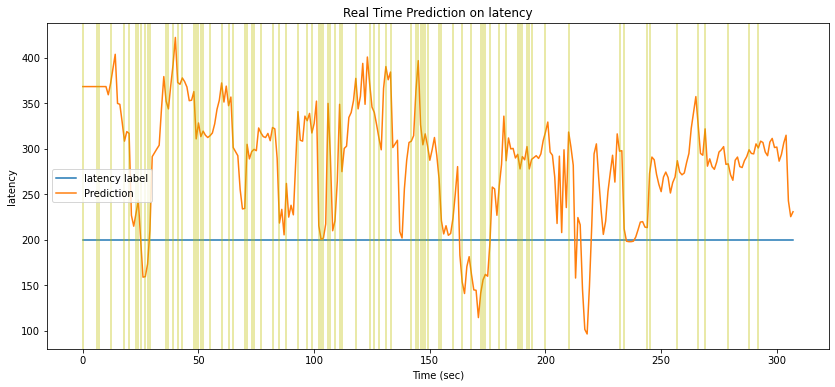

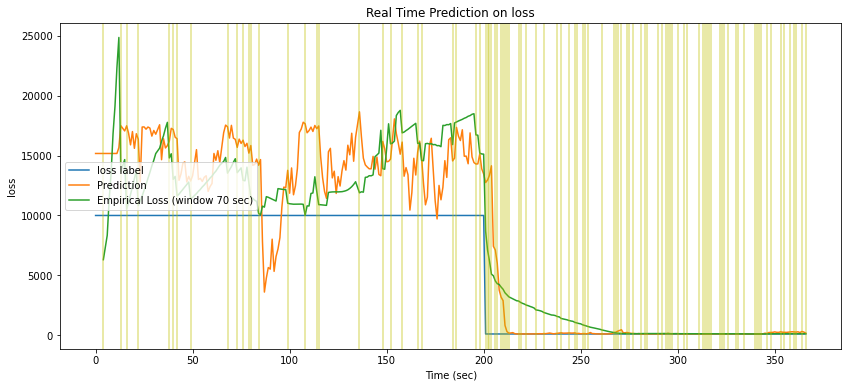

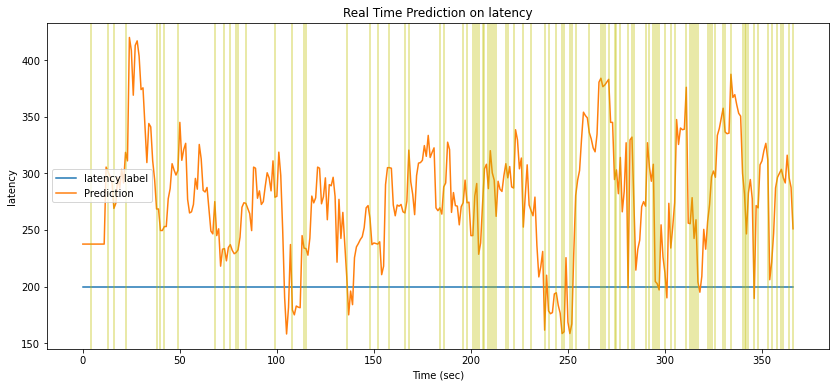

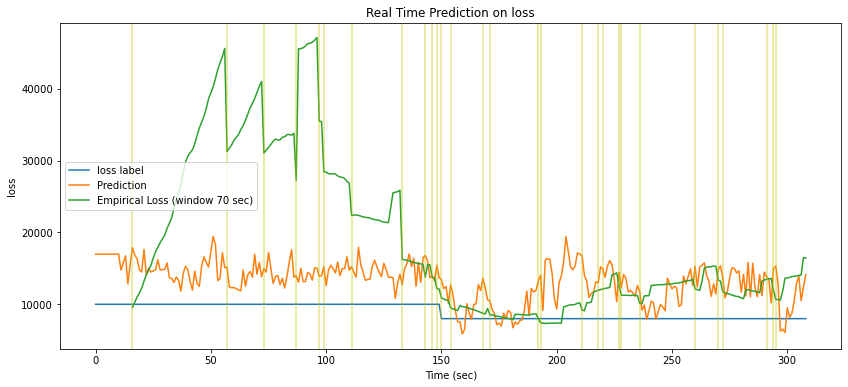

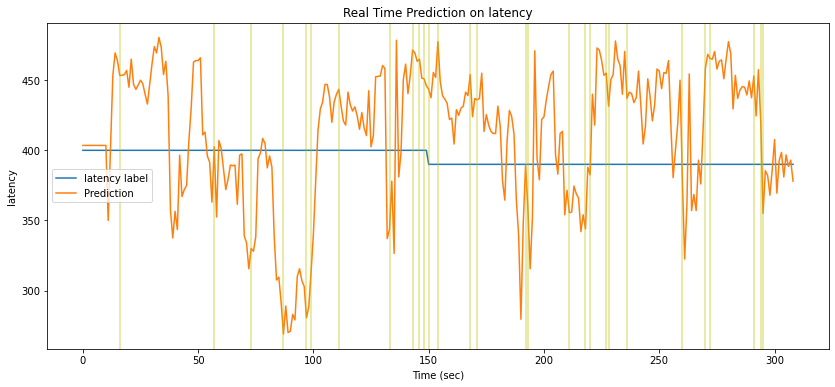

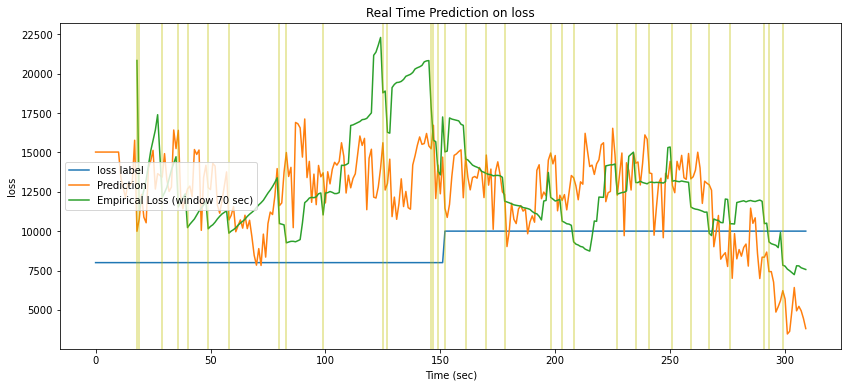

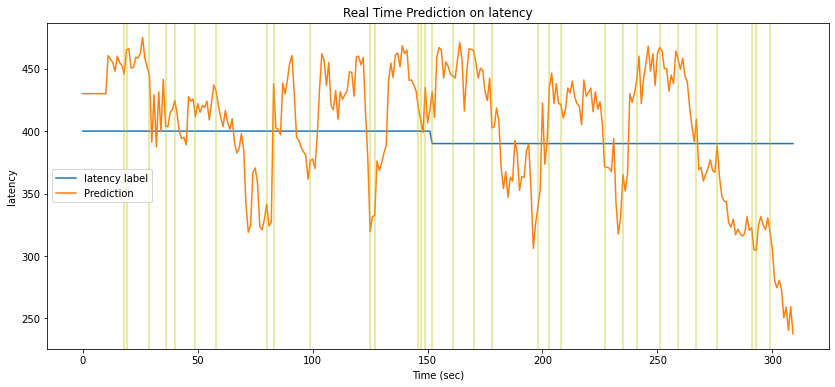

In [49]:
dir_ = 'data/jennawk5data'
lst = []
for i in [x for x in listdir(dir_) if not 'losslog' in x]:
    # the_csv_youre_using = listdir(dir_)

    mergedtable = readfilerun_simple(os.path.join(dir_, i), dir_) # merges losslog. make sure you have losslog in the same train_c directory
    df_ = genfeat(mergedtable) # generates all the adjacent features we train on!
    gen_model(df_, 'loss', 70)
    gen_model(df_, 'latency', 70)
    lst.append(df_)
lst[0]

In [41]:
lst[0]

,Time,IP1,Port1,IP2,Port2,Proto,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts,...,mean_tdelta,max_tdelta,number_ms,total_pkt_sizes,pkt_ratio,time_spread,byte_ratio,prediction,pred_loss,pred_latency
0,1643677660,192.168.96.3,47330,192.168.48.2,5001,6,13664,60,11,1,...,0.000000,0,1,13724,1143.666667,0,1143.666667,401.5,763.0,492.5
1,1643677661,192.168.96.3,47330,192.168.48.2,5001,6,51000,1520,34,26,...,13.694915,402,8,52520,875.333333,808,875.333333,401.5,119.5,424.0
2,1643677662,192.168.96.3,47330,192.168.48.2,5001,6,42000,1456,28,28,...,7.400000,399,9,43456,776.000000,407,776.000000,401.5,117.0,376.0
4,1643677663,192.168.96.3,47330,192.168.48.2,5001,6,63000,1196,42,23,...,12.656250,400,11,64196,987.630769,810,987.630769,401.5,108.0,387.0
5,1643677664,192.168.96.3,47330,192.168.48.2,5001,6,42000,728,28,14,...,9.878049,399,7,42728,1017.333333,405,1017.333333,401.5,108.0,398.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,1643677957,192.168.96.3,47330,192.168.48.2,5001,6,1807500,24232,1205,466,...,0.583234,33,243,1831732,1096.189108,974,1096.189108,289.0,11030.0,289.0
304,1643677958,192.168.96.3,47330,192.168.48.2,5001,6,1576500,21788,1051,419,...,0.675970,36,199,1598288,1087.270748,993,1087.270748,313.0,11310.0,313.0
305,1643677959,192.168.96.3,47330,192.168.48.2,5001,6,2160000,29224,1440,562,...,0.493253,34,223,2189224,1093.518482,987,1093.518482,271.5,12340.0,271.5
306,1643677960,192.168.96.3,47330,192.168.48.2,5001,6,1881000,26884,1254,517,...,0.554802,35,210,1907884,1077.291925,982,1077.291925,260.0,12090.0,260.0


In [91]:
# loss from 10000 to 100
loss10000to100 = lst[1]

<AxesSubplot:>

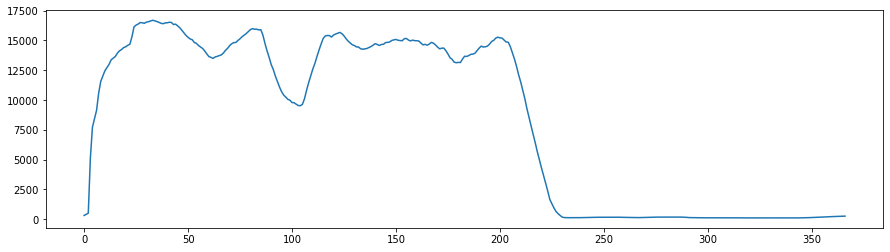

In [92]:
loss10000to100['pred_loss'].rolling(20, min_periods=1).mean().plot(figsize=(15,4))

<AxesSubplot:>

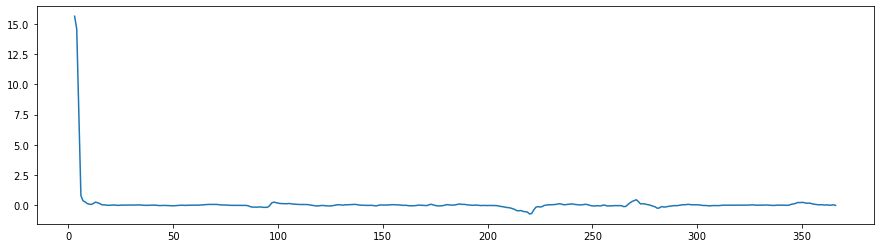

In [90]:
blah = lst[1]['pred_loss'].rolling(10, min_periods=1).mean().pct_change(2) #.plot(figsize=(15,4))
blah.plot(figsize=(15,4))

<AxesSubplot:>

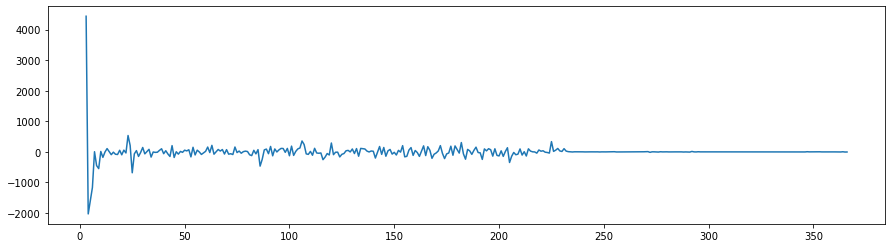

In [79]:
blah = lst[1]['pred_loss'].rolling(20, min_periods=1).mean().diff().diff()#.plot(figsize=(15,4))
blah.plot(figsize=(15,4))

In [ ]:
def plot_different_windowsizes(windowsize=20):
    tempdf = df[['loss', 'pred_loss', 'latency', 'pred_latency']]
    tempdf['smoothed_pred_loss'] = tempdf['pred_loss'].rolling(windowsize,min_periods=1).mean()
    tempdf['smoothed_pred_latency'] = tempdf['pred_latency'].rolling(windowsize,min_periods=1).mean()
    tempdf[['loss', 'pred_loss', 'smoothed_pred_loss']].plot(title=f'predicted loss smoothed over rolling window of {windowsize}', figsize=(10,2))
    tempdf[['latency', 'pred_latency', 'smoothed_pred_latency']].plot(title=f'predicted latency smoothed over rolling window of {windowsize}', figsize=(10,2))
plot_different_windowsizes()

In [112]:
loss10000to100['pctc2'] = loss10000to100['pred_loss'].rolling(10, min_periods=1).mean().pct_change(2)
loss10000to100['pctc2_smooth'] = loss10000to100['pred_loss'].pct_change(2)
loss10000to100['pctc2']

0            NaN
2            NaN
3      45.731707
4      21.743947
6       0.034099
         ...    
362     0.036697
363    -0.144250
364     0.099115
365     0.193622
366    -0.478261
Name: pctc2, Length: 360, dtype: float64

In [113]:
loss10000to100['pctc2'] <= 0.2

0      False
2      False
3      False
4      False
6       True
       ...  
362     True
363     True
364     True
365     True
366     True
Name: pctc2, Length: 360, dtype: bool

In [114]:
loss10000to100['loss']

0      10000
2      10000
3      10000
4      10000
6      10000
       ...  
362      100
363      100
364      100
365      100
366      100
Name: loss, Length: 360, dtype: int64

not looking for bad traffic
but traffic that is getting worse

In [115]:
loss10000to100[loss10000to100['pctc2'] <= -0.2].index

Int64Index([ 23,  43,  86,  87,  88, 117, 138, 162, 169, 170, 175, 176, 205,
            206, 208, 209, 210, 211, 212, 213, 214, 216, 217, 218, 236, 248,
            249, 257, 259, 272, 273, 276, 277, 279, 282, 366],
           dtype='int64')

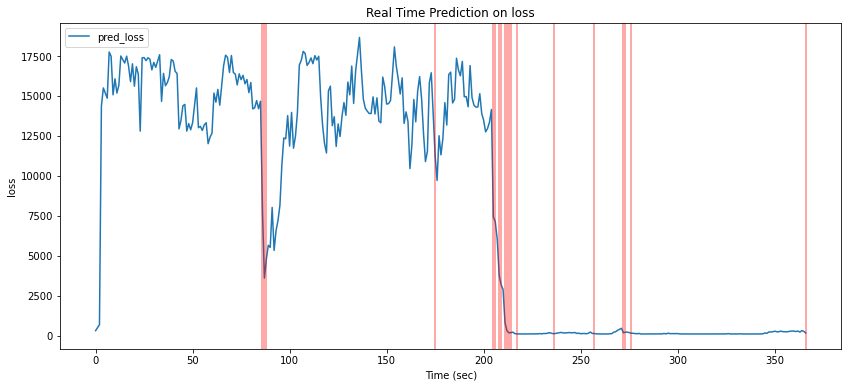

In [116]:
loss10000to100['pctc2'] = loss10000to100['pred_loss'].rolling(10, min_periods=1).mean().pct_change(2)
loss10000to100['pctc2_smooth'] = loss10000to100['pred_loss'].pct_change(2)
loss10000to100['pctc2']

plt.figure(figsize=(14,6))
loss10000to100['pred_loss'].plot(title=f'Real Time Prediction on loss', 
        xlabel='Time (sec)', ylabel='loss')
plt.legend()
for i in loss10000to100[loss10000to100['pctc2'] <= -0.3].index: # indices where negative percent change is higher than 0.3
    plt.axvline(x=i, color='r', alpha=.45)